In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.colors

In [ ]:
amazon_data = pd.read_csv("/content/drive/MyDrive/Datasets-Streaming/amazon_prime_titles.csv")
amazon_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


In [ ]:
for col in amazon_data.columns:
    null_rate = amazon_data[col].isna().sum() / np.shape(amazon_data)[0] * 100 
    if null_rate > 0 :
        print("{} null rate: {}%".format(col,round(null_rate,2)))

director null rate: 21.53%
cast null rate: 12.75%
country null rate: 93.05%
date_added null rate: 98.4%
rating null rate: 3.49%


In [ ]:
amazon_data['country'] = amazon_data['country'].fillna(amazon_data['country'].mode()[0])
amazon_data['cast'] = amazon_data['cast'].fillna("No data")
amazon_data['director'] = amazon_data['director'].fillna("No Data")
amazon_data['date_added'] = amazon_data['date_added'].fillna("No Data")
amazon_data["rating"] = amazon_data["rating"].fillna("No Data")
amazon_data.dropna(how = "all",inplace=True)
amazon_data.drop_duplicates( inplace=True)
amazon_data.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

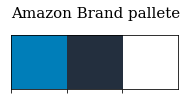

In [ ]:
sns.palplot(['#007eb9','#232f3e','#ffffff'])
plt.title("Amazon Brand pallete", loc = "left",fontfamily="serif",fontsize=15,y=1.2)
plt.show()

In [ ]:
amazon_data.columns.unique()

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

Amazon Movie and show ratio


In [ ]:
x = pd.DataFrame(amazon_data.groupby('type')['type'].count())
x.head()

,type
type,
Movie,7814
TV Show,1854


In [ ]:
import plotly.express as px

In [ ]:
fig = px.pie(x,values='type',names=x.index,width=600,height=600)
fig.update_traces(textposition = "inside",textinfo = 'percent+label',hole=0.8,marker = dict(colors=['#007eb9','#232f3e'],line=dict(color="white",width=2)))
fig.show()

In [ ]:
amazon_data['count'] =1
amazon_data['first_country'] = amazon_data['country'].apply(lambda x:x.split(",")[0])
amazon_data['first_country'].head()


0            Canada
1             India
2     United States
3     United States
4    United Kingdom
Name: first_country, dtype: object

In [ ]:
data = amazon_data.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data.head()

,count
first_country,
United States,9288
India,238
United Kingdom,48
Canada,25
Italy,10


Top 5 countries


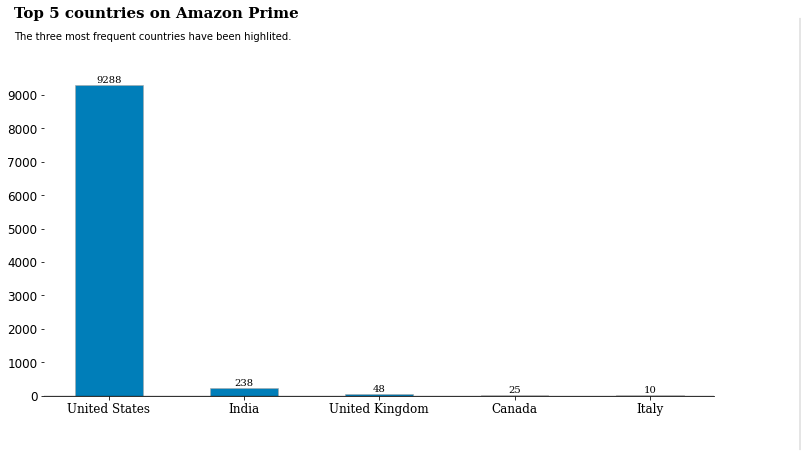

In [ ]:
data = amazon_data.groupby('first_country')['count'].sum().sort_values(ascending=False)[:5]
color_map = ['#f5f5f1' for _ in range(5)]
color_map[0] = color_map[1] = color_map[2] = "#007eb9"
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(data.index,data,width=0.5,edgecolor="darkgray",linewidth=0.6,color=color_map)
for i in data.index:
  ax.annotate(f"{data[i]}",
              xy=(i,data[i]+150),
              va = "center",ha="center",fontweight="light",fontfamily="serif")
  
for s in ['top','left','right']:
  ax.spines[s].set_visible(False)

ax.set_xticklabels(data.index, fontfamily = 'serif', rotation=0)
fig.text(0.09,1,'Top 5 countries on Amazon Prime',fontsize = 15, fontweight = "bold",fontfamily="serif")
fig.text(0.09,0.95,"The three most frequent countries have been highlited.")
grid_y_ticks = np.arange(0,10000,1000)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)
plt.axhline(y=0,color="black",linewidth=1.3,alpha=0.7)
ax.tick_params(axis="both",which="major",labelsize=12)
import matplotlib.lines as lines 
l1 = lines.Line2D([1,1],[0,1],transform=fig.transFigure,figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])
plt.show()

In [ ]:
country_order = amazon_data['first_country'].value_counts()[:5].index
data_q2q3 = amazon_data[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]

In [ ]:
data_q2q3['sum'] = data_q2q3.sum(axis=1)

In [ ]:
data_q2q3_ratio =(data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]

In [ ]:
data_q2q3_ratio

type,Movie,TV Show
Italy,0.800000,0.200000
United States,0.805017,0.194983
United Kingdom,0.833333,0.166667
Canada,0.920000,0.080000
India,0.932773,0.067227


In [ ]:
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#007eb9', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#232f3e', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.93, 'Top 5 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')



import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

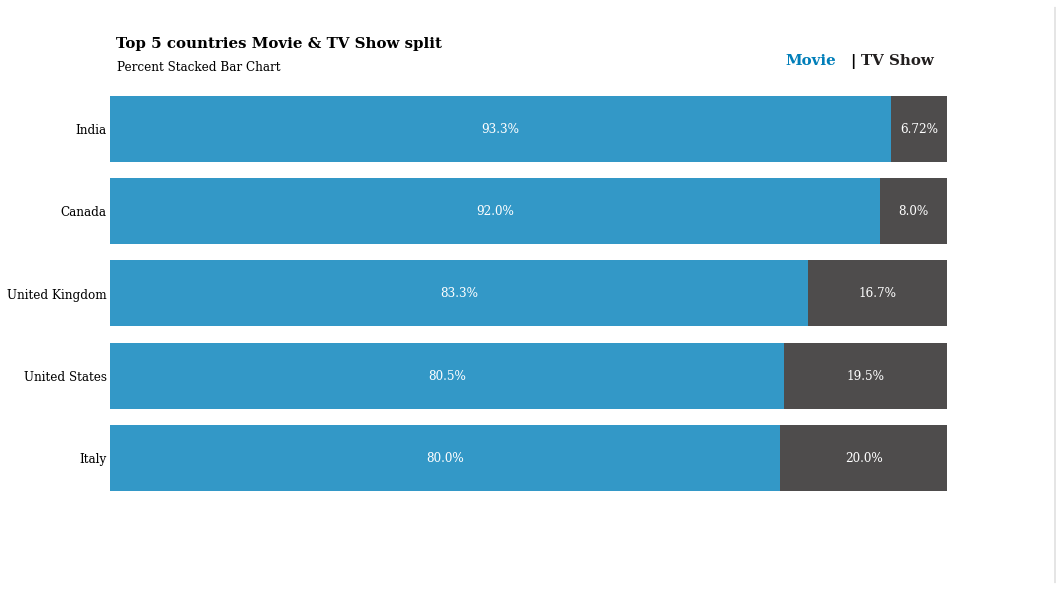

In [ ]:
country_order = amazon_data['first_country'].value_counts()[:5].index
data_q2q3 = amazon_data[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#007eb9', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.93, 'Top 5 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    

fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#007eb9')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.82,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')





import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [ ]:
order = pd.DataFrame(amazon_data.groupby('rating')['count'].sum().sort_values(ascending=False).reset_index())
rating_order = list(order['rating'])

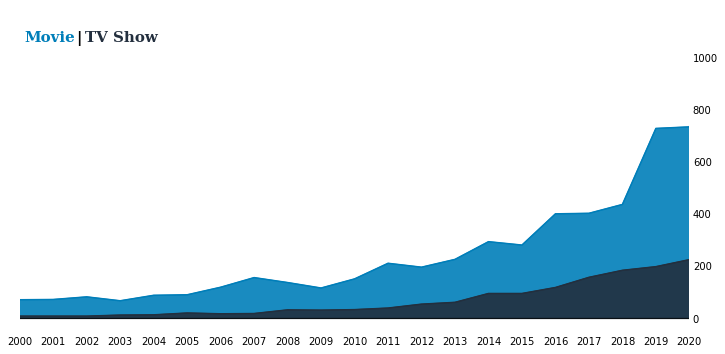

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ['#007eb9','#232f3e']

for i, mtv in enumerate(amazon_data['type'].value_counts().index):
    mtv_rel = amazon_data[amazon_data['type']==mtv]['release_year'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=color[i], label=mtv)
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], alpha=0.9)
    
ax.yaxis.tick_right()
    
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

#ax.set_ylim(0, 50)
#ax.legend(loc='upper left')
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2000, 2021, 1))


fig.text(0.13,0.8,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#007eb9')
fig.text(0.19,0.8,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.8,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#232f3e')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer 

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",['#007eb9','#232f3e'])
def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the amazon {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))

    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    plt.show()

There are 30 types in the amazon Movie Dataset


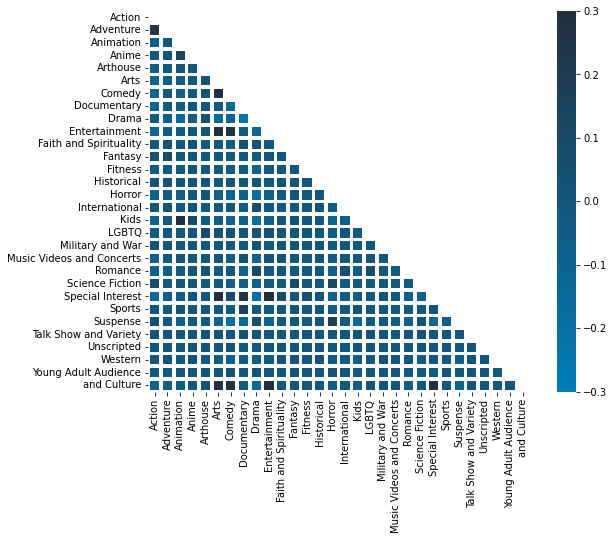

In [ ]:
df_tv = amazon_data[amazon_data["type"]==" TV show"]
df_movies = amazon_data[amazon_data["type"]=="Movie"]
genre_heatmap(df_movies,"Movie")
plt.show()

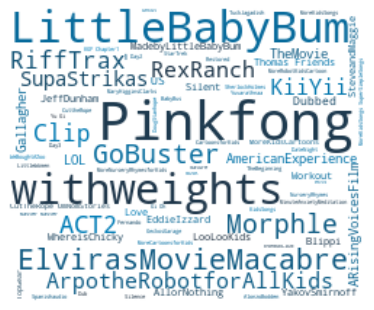

In [ ]:
from wordcloud import WordCloud
import random
from PIL import Image
import matplotlib

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",['#007eb9','#232f3e'])
text = str(list(amazon_data['title'])).replace(' ','').replace('[', '').replace("'", '').replace(']', '').replace('.', '').replace('4KUHD',"").replace("Tamil","").replace("Telugu","").replace("Hindi","").replace("Kannada","").replace("Subtitled","").replace("Malayalam","").replace("English","")
mask = np.array(Image.open('/content/drive/MyDrive/Datasets-Streaming/download (1).png'))
wordcloud = WordCloud(background_color= "white",width = 500,  height = 200,colormap=cmap, max_words = 150, mask = mask).generate(text)

plt.figure( figsize=(5,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
amazon_data['description'] = amazon_data['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(amazon_data['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(9668, 28947)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
indicies = pd.Series(amazon_data.index,index= amazon_data['title']).drop_duplicates()

In [ ]:
indicies['Pink: Staying True']

3

In [ ]:
from numpy.core.numeric import indices
def get_recomendations(title,cosine_sim = cosine_sim):
  idx = indicies[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores,key = lambda x:x[1],reverse=True)
  sim_scores = sim_scores[1:11]
  movie_indicies = [i[0] for i in sim_scores]
  return amazon_data['title'].iloc[movie_indicies]


In [ ]:
 s = get_recomendations('Pink: Staying True')
 s = pd.DataFrame(s)

In [ ]:
s

,title
7408,Eddie Izzard: Force Majeure
1569,Murder City Devils - Rock & Roll Won't Wait
5777,The Booksellers
1887,Led Zeppelin - Physical Graffiti: A Classic Al...
6539,Pink - Love of Girls
3855,Happiness Continues: A Jonas Brothers Concert ...
2809,Coldplay: A Head Full Of Dreams
3742,The Doors - When You're Strange
246,TV in Black: The First Fifty Years
8857,Secrets of the Mega Resort


In [ ]:
books=pd.read_csv('/content/drive/MyDrive/Datasets-Streaming/netflix_data/books.csv')
books['original_title']=books['original_title'].str.lower()
x=amazon_data
x['title']=x['title'].str.lower()
t=x.merge(books, left_on='title', right_on='original_title', how="inner")

In [ ]:
t

,show_id,type,title_x,director,cast,country,date_added,release_year,rating,duration,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,s145,Movie,we need to talk about kevin,Lynne Ramsay,"Tilda Swinton, John C. Reilly, Ezra Miller",United States,No Data,2012,R,113 min,...,101343,113939,11369,3643,5596,16884,41057,46759,https://images.gr-assets.com/books/1327865017m...,https://images.gr-assets.com/books/1327865017s...
1,s166,Movie,waiting for you,Charles Garrad,"Colin Morgan, Fanny Ardant, Abdelkrim Bahloul,...","United Kingdom, France",No Data,2018,13+,92 min,...,20236,20656,798,532,1570,5478,6263,6813,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
2,s183,Movie,violets are blue,Jack Fisk,"Sissy Spacek, Kevin Kline, Bonnie Bedelia",United States,No Data,1986,PG-13,86 min,...,41555,44214,940,400,1758,11115,17683,13258,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
3,s227,TV Show,undeniable,No Data,"Claire Goose, Peter Firth, Felix Scott, Pippa ...",United States,No Data,2014,16+,1 Season,...,38501,44425,4428,1760,2327,6763,13460,20115,https://images.gr-assets.com/books/1356218855m...,https://images.gr-assets.com/books/1356218855s...
4,s259,Movie,true colors,Herbert Ross,"Richard Widmark, Dina Merrill, Philip Bosco, P...",United States,No Data,1991,R,110 min,...,31276,34222,2724,418,1813,8585,13553,9853,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,s9607,Movie,blue moon,Ron Lagomarsino,"Sharon Lawrence, Jeffrey Nordling, Richard Kil...",United States,No Data,1999,18+,92 min,...,74367,78447,3611,3935,9508,21715,21521,21768,https://images.gr-assets.com/books/1362336365m...,https://images.gr-assets.com/books/1362336365s...
281,s9612,Movie,wild fire,Esther Abah,Wole Ojo Mary Lazarus Neye Balogun,United States,No Data,2021,16+,80 min,...,18529,20172,959,192,740,4446,8588,6206,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
282,s9613,Movie,white night,"Sonny Atkins, P.H. Bergeron, Brian Hamilton, M...",No data,United States,No Data,2021,13+,87 min,...,73534,80439,1851,109,558,7558,30249,41965,https://images.gr-assets.com/books/1309552288m...,https://images.gr-assets.com/books/1309552288s...
283,s9624,Movie,the princess bride,Rob Reiner,"Cary Elwes, Mandy Patinkin, Chris Sarandon, Ch...",United States,No Data,1987,PG,98 min,...,628637,658042,15630,12883,21641,89236,196047,338235,https://images.gr-assets.com/books/1327903636m...,https://images.gr-assets.com/books/1327903636s...


In [ ]:
import plotly.graph_objects as go

labels = ['Shows from books','Shows not from books']
values = [285
          ,6234]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()